In [1]:
import matplotlib.pyplot as plt
import numpy as np

import iris
import iris.quickplot as qplt

%matplotlib inline

In [2]:
#fname = '/g/data/r87/dbi599/ohc-metrics_Omon_ACCESS1-0_historical_r1i1p1_all.nc'
fname = '/g/data/r87/dbi599/drstree/CMIP5/GCM/CSIRO-BOM/ACCESS1-0/historical/mon/ocean/inttemp/r1i1p1/inttemp_Omon_ACCESS1-0_historical_r1i1p1_all_drift.nc'

In [7]:
cube_globe = iris.load_cube(fname, 'integrated temperature globe')
cube_sthext = iris.load_cube(fname, 'integrated temperature southern extratropics')
cube_notsthext = iris.load_cube(fname, 'integrated temperature outside southern extratropics')

In [8]:
print cube_globe

integrated temperature globe / (10^19 K m3) (time: 120)
     Dimension coordinates:
          time                                   x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: inttemp integrated over full depth of input data (5.000000 down to 583...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Tue May 17 15:16:52 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth Scient

In [9]:
cube_globe = cube_globe.rolling_window('time', iris.analysis.MEAN, 12)
cube_sthext = cube_sthext.rolling_window('time', iris.analysis.MEAN, 12)
cube_notsthext = cube_notsthext.rolling_window('time', iris.analysis.MEAN, 12)

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/cube.py:3381: UserWarning: The bounds of coordinate u'time' were ignored in the rolling window operation.
  'the rolling window operation.' % coord_.name())


In [10]:
print cube_globe

integrated temperature globe / (10^19 K m3) (time: 109)
     Dimension coordinates:
          time                                   x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: inttemp integrated over full depth of input data (5.000000 down to 583...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Tue May 17 15:16:52 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth Scient

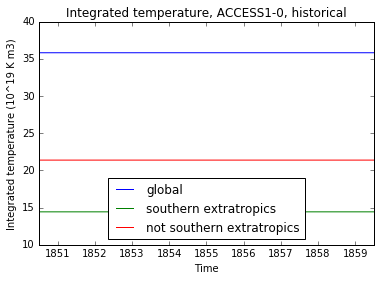

In [11]:
qplt.plot(cube_globe.coord('time'), cube_globe, label='global')
qplt.plot(cube_sthext.coord('time'), cube_sthext, label='southern extratropics')
qplt.plot(cube_notsthext.coord('time'), cube_notsthext, label='not southern extratropics')

plt.legend(loc='best')
plt.title('Integrated temperature, ACCESS1-0, historical')
plt.ylabel('Integrated temperature (%s)' %(cube_globe.units))

qplt.show()

In [10]:
ratio = (cube_sthext + 40) / (cube_notsthext + 40)

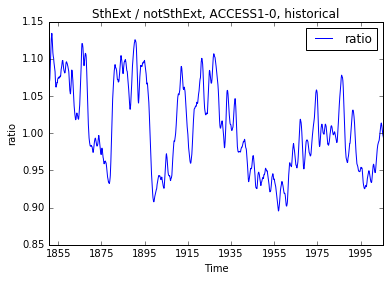

In [11]:
qplt.plot(ratio.coord('time'), ratio, label='ratio')

plt.legend(loc='best')
plt.title('SthExt / notSthExt, ACCESS1-0, historical')
plt.ylabel('ratio')

qplt.show()

Now that I've got the dummy ratio data, I need to take the linear trend in 10 year windows. I'm following the example of how to make an aggregator in Iris found [here](http://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html#general-custom-aggregation).

In [24]:
from iris.util import rolling_window
from iris.analysis import Aggregator
from scipy import stats
import numpy

In [13]:
print ratio

unknown / (1)                       (time: 1861)
     Dimension coordinates:
          time                           x


In [41]:
windowed_ratio = rolling_window(ratio.data, window=10, axis=0)

In [42]:
print windowed_ratio.shape

(1852, 10)


In [49]:
def calc_slope(y, x):
    """ """
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    return slope


def linear_trend(data, axis, window_size):
    """ """

    window_array = rolling_window(data, window=window_size, axis=axis)

    x_axis = numpy.arange(0, window_size)    
    trend = numpy.apply_along_axis(calc_slope, -1, window_array, x_axis)
    
    return trend
    

In [50]:
ratio_trends = linear_trend(ratio.data, 0, 10)

In [51]:
ratio_trends.shape

(1852,)

In [52]:
ratio_trends[0]

0.00012627298181707209

In [54]:
stats.linregress(x, y)

masked_array(data = [1.0844049453735352 1.0782850980758667 1.0737272500991821
 1.0706371068954468 1.0686872005462646 1.069010853767395 1.070595145225525
 1.0732098817825317 1.0793673992156982 1.0861436128616333],
             mask = [False False False False False False False False False False],
       fill_value = 1e+20)

In [55]:
stats.linregress(numpy.arange(0, 10), ratio.data[0:10])

LinregressResult(slope=0.00012627298181707209, intercept=1.0748386805707759, rvalue=0.060463101353587873, pvalue=0.86821943154420533, stderr=0.00073702076532019807)

In [65]:
trend_cube = iris.cube.Cube(ratio_trends, dim_coords_and_dims=[(ratio.coord('time')[4:-5], 0)])

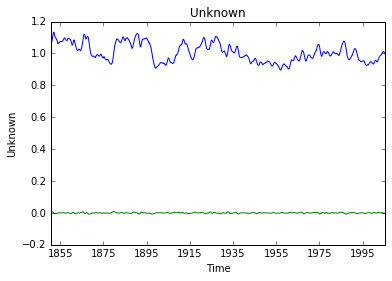

In [66]:
qplt.plot(ratio.coord('time'), ratio, label='ratio')
qplt.plot(trend_cube.coord('time'), trend_cube, label='ratio')

#plt.legend(loc='best')
#plt.title('SthExt / notSthExt, ACCESS1-0, historical')
#plt.ylabel('ratio')

qplt.show()

In [58]:
ratio.coord('time')[4:-5].shape

(1852,)

In [63]:
dir(ratio.coord('time'))

['_MODE_ADD',
 '_MODE_DIV',
 '_MODE_MUL',
 '_MODE_RDIV',
 '_MODE_SUB',
 '_MODE_SYMBOL',
 '__abstractmethods__',
 '__add__',
 '__binary_operator__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_as_defn',
 '_attributes',
 '_bounds',
 '_guess_bounds',
 '_points',
 '_repr_other_metadata',
 '_sanity_check_contiguous',
 '_standard_name',
 '_str_dates',
 '_units',
 '_value_type_name',
 '_var_name',
 '_xml_id',
 'attributes',
 'bounds',
 'cell',
 'cells',
 'circular',
 'collapsed',
 'contiguous_bo